<font size=3> **Goal:** The purpose of this notebook is to analyze the results after doing equilibration procedure on the full one square degree and compare them to previous results, see if we can proceed to money plot, etc. </font>

# Preamble

In [1]:
import os
from importlib import reload
os.chdir('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD')

%matplotlib inline 

import mycode
reload(mycode);

In [2]:
from mycode import money
from mycode import preamble
from mycode import weights 
from mycode import maps 

from tqdm import tqdm 

%run mycode/preamble.py

reload(weights)
reload(preamble)
reload(maps)
reload(money);

In [51]:
import astroML
import subprocess
from astroML.plotting import scatter_contour

In [4]:
from astropy.table import Table

In [5]:
data_dir = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data'

## Read catalogues

In [6]:
#filters to apply as reading the catalogue. 
pfilters = [
    maps.get_non_duplicated_cat
]

#filters to be applied uniformly ignoring the selection effect. 
afilters=[
    maps.get_not_dropped_cat, #does not commute with the other ones, so do first. 
    maps.not_dropped, #redundant. 
    maps.low_cond,
]


ffilters = [
    maps.good, 
    maps.best,
]

### testing 

In [7]:
pcat1, pcat2 = (Table.read(f"{data_dir}/projectLSST-g1_0-g2_0/final_fits.fits"), 
            Table.read(f"{data_dir}/projectLSST-g1_20-g2_0/final_fits.fits"))

pfcat1, pfcat2 = (Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), 
            Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits"))

In [8]:
cat1, cat2 = maps.get_filter_cats([pcat1, pcat2], pfilters) 
fcat1, fcat2 = maps.get_filter_cats([pfcat1, pfcat2], pfilters) 

#check lengths. 
print(len(cat1), len(cat2))
print(len(fcat1), len(fcat2))

802101 802031
802101 802031


In [9]:
scat1, scat2 = maps.get_filter_cats([cat1, cat2], afilters)

scat1 = maps.get_filter_cats([scat1], ffilters)[0]
print(len(scat1))

#remember to not apply filters directly on cat2, but intersect
scat1, scat2 = maps.get_intersection_cats([scat1, scat2]) 
print(len(scat1),len(scat2))

77718
77244 77244


In [10]:
fscat1, fscat2 = maps.get_filter_cats([fcat1, fcat2], afilters)


fscat1 = maps.get_filter_cats([fscat1], ffilters)[0]
print(len(fscat1))

#remember to not apply filters directly on cat2, but intersect
fscat1, fscat2 = maps.get_intersection_cats([fscat1, fscat2]) 
print(len(fscat1),len(fscat2))

112840
112701 112701


### read all 

In [18]:
pcats = [
        Table.read(f"{data_dir}/fprojectLSST-g1_-20-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-5-g2_0/final_fits.fits"),
        Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_5-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits")
        ]

In [19]:
cats = maps.get_filter_cats(pcats, pfilters) 
[len(cat) for cat in cats]

[802149, 802075, 802121, 802182, 802101, 802074, 802166, 802013, 802031]

In [20]:
scats = maps.get_filter_cats(cats, afilters)
[len(cat) for cat in scats]

[798603, 798493, 798538, 798477, 798386, 798376, 798460, 798309, 798198]

In [21]:
fcat1 = maps.get_filter_cats([scats[4]], ffilters)[0]
print(len(fcat1))
scats.pop(4)
scats.insert(4, fcat1) 
print(len(scats))

112840
8


In [28]:
# #remember to not apply filters directly on cat2, but intersect
# fcats = maps.get_intersection_cats(scats)

# [len(cat) for cat in fcats]

[112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574]

In [54]:
# subprocess.run("mkdir data/fcats", shell=True)
# for i,cat in enumerate(fcats): 
#     cat.write( f"data/fcats/fcat{i}.fits", "fits" )
    

In [ ]:
fcats = [Table.read( f"data/fcats/fcat{i}.fits") for i in range(9)]

# Condition numbers

In [31]:
conds1 = np.log10(cat1[(fcat1['cond_num_grp'] < 1e20) & (cat1['cond_num_grp'] < 1e20)]['cond_num_grp'])
conds2 = np.log10(fcat1[(fcat1['cond_num_grp'] < 1e20) & (cat1['cond_num_grp'] < 1e20)]['cond_num_grp'])

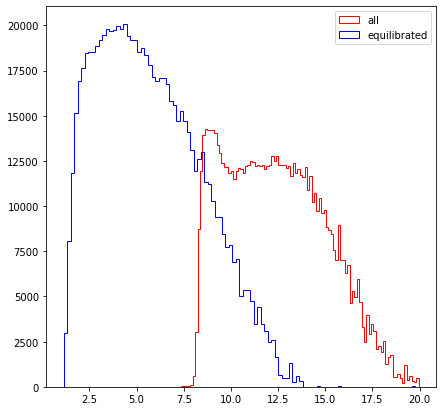

In [32]:
plt.figure(figsize=(7,7))
plt.hist(conds1, bins=100, color='red', 
         histtype='step', label='all');
plt.hist(conds2, bins=100, color='blue' ,
         histtype='step', label='equilibrated');
plt.legend()

<font size=3> **Note:** No significant difference found for the histograms in the case of applied shear case </font>

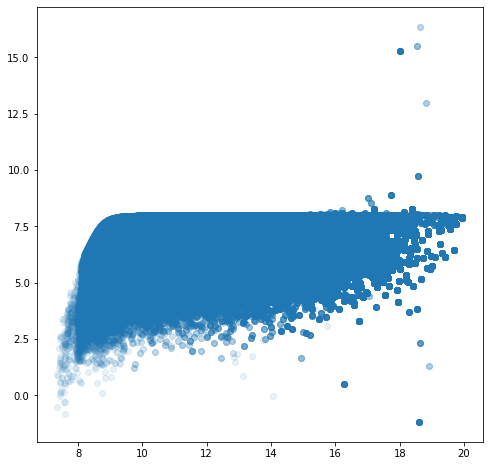

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(conds1, conds1 - conds2, alpha=0.1)

# Weighting

In [77]:
def weights_bias_scatter(ax, cat, component, iso_or_grp, xlabel=None, title=None, xlim=(-5,5), size_dots=0.5, alpha=1): 
    orig_ids = list(range(len(cat)))
    ws = weights.get_weights(orig_ids, cat,  component, iso_or_grp, 'component')
    suffix = weights.get_iso_or_grp_suffix(iso_or_grp)

    ax.scatter(cat[f'bias_g{component}{suffix}'], ws, alpha=alpha, s=size_dots, c='b')
    ax.set_title(title, size = 18 )
    ax.set_xlabel(xlabel, size=18)
    ax.set_ylabel('Weights', size=18)
    ax.set_xlim(xlim)

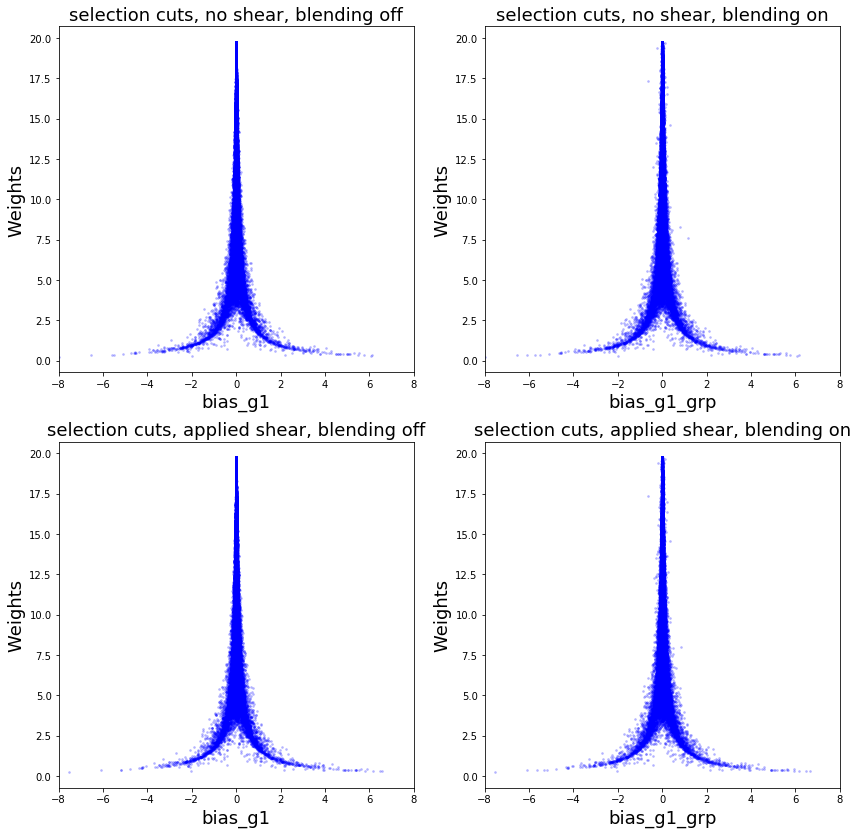

In [88]:
fig, axs = plt.subplots(2,2,figsize=(14,14))
axes = axs.flatten()
weights_bias_scatter(axes[0], fscat1, '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="bias_g1", title="selection cuts, no shear, blending off")

weights_bias_scatter(axes[1], fscat1, '1', 'grp', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="bias_g1_grp", title="selection cuts, no shear, blending on")

weights_bias_scatter(axes[2], fscat2, '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="bias_g1", title="selection cuts, applied shear, blending off")

weights_bias_scatter(axes[3], fscat2, '1', 'grp', xlim=[-8,8], size_dots=3, alpha=0.2,
                     xlabel="bias_g1_grp", title="selection cuts, applied shear, blending on")

## outliers?

In [97]:
ws_grp = weights.get_weights(list(range(len(fscat1))), fscat1, '1', 'grp', which_shape_noise='component')
cond1 = (ws_grp> 10)
cond2 = (np.absolute(fscat1['bias_g1_grp']) > 0.5 )
fscat1[cond1 & cond2]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,cond_num,cond_num_grp,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402702075926,402702075926,3,0,1,5943,5962,5480,5498,0.99134684,0.008653155,-609.43994,17.889114,1.0604616,24.39512,0.3437271,124136.45,0.43053705,0.4393904,0.058692172,-0.13002834,0.4970418,0.3729307,-0.57339776,0.75692636,0.9873779,28.92598,28.780598,28.780264,18.337465,16.47349,0.08965598,0.07731721,0.08001852,0.09715037,0.08370334,0.08586125,825.73145,21801672.0,367.09695,-0.007279529,0.001445069,-0.003193984,-7.566406e-07,3.6597818e-08,-57492.523,-0.58481675,-0.6242049,0.20370696,0.22936146,-0.06164475,139,False


In [98]:
ws_grp = weights.get_weights(list(range(len(fscat2))), fscat2, '1', 'grp', which_shape_noise='component')
cond1 = (ws_grp> 10)
cond2 = (np.absolute(fscat2['bias_g1_grp']) > 0.5 )
fscat2[cond1 & cond2]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,cond_num,cond_num_grp,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402702075926,402702075926,3,0,1,5942,5962,5480,5498,0.99134684,0.008653155,-609.43994,17.889114,1.0604616,24.39512,0.3437271,124136.45,0.43062317,0.44066414,0.07893673,-0.12967084,0.50181097,0.3695342,-0.51198506,0.7574357,0.9869617,28.908684,28.763556,28.763206,18.330292,16.399374,0.08991309,0.07755667,0.079949714,0.09748346,0.08401786,0.08603185,831.5201,22438136.0,366.8613,-0.007342352,0.0016937036,-0.0032032984,-4.980489e-07,-1.0122217e-07,-58379.055,-0.5790645,-0.6262154,0.20624898,0.23626676,-0.061974607,138,False


## outliers in other catalogues? 


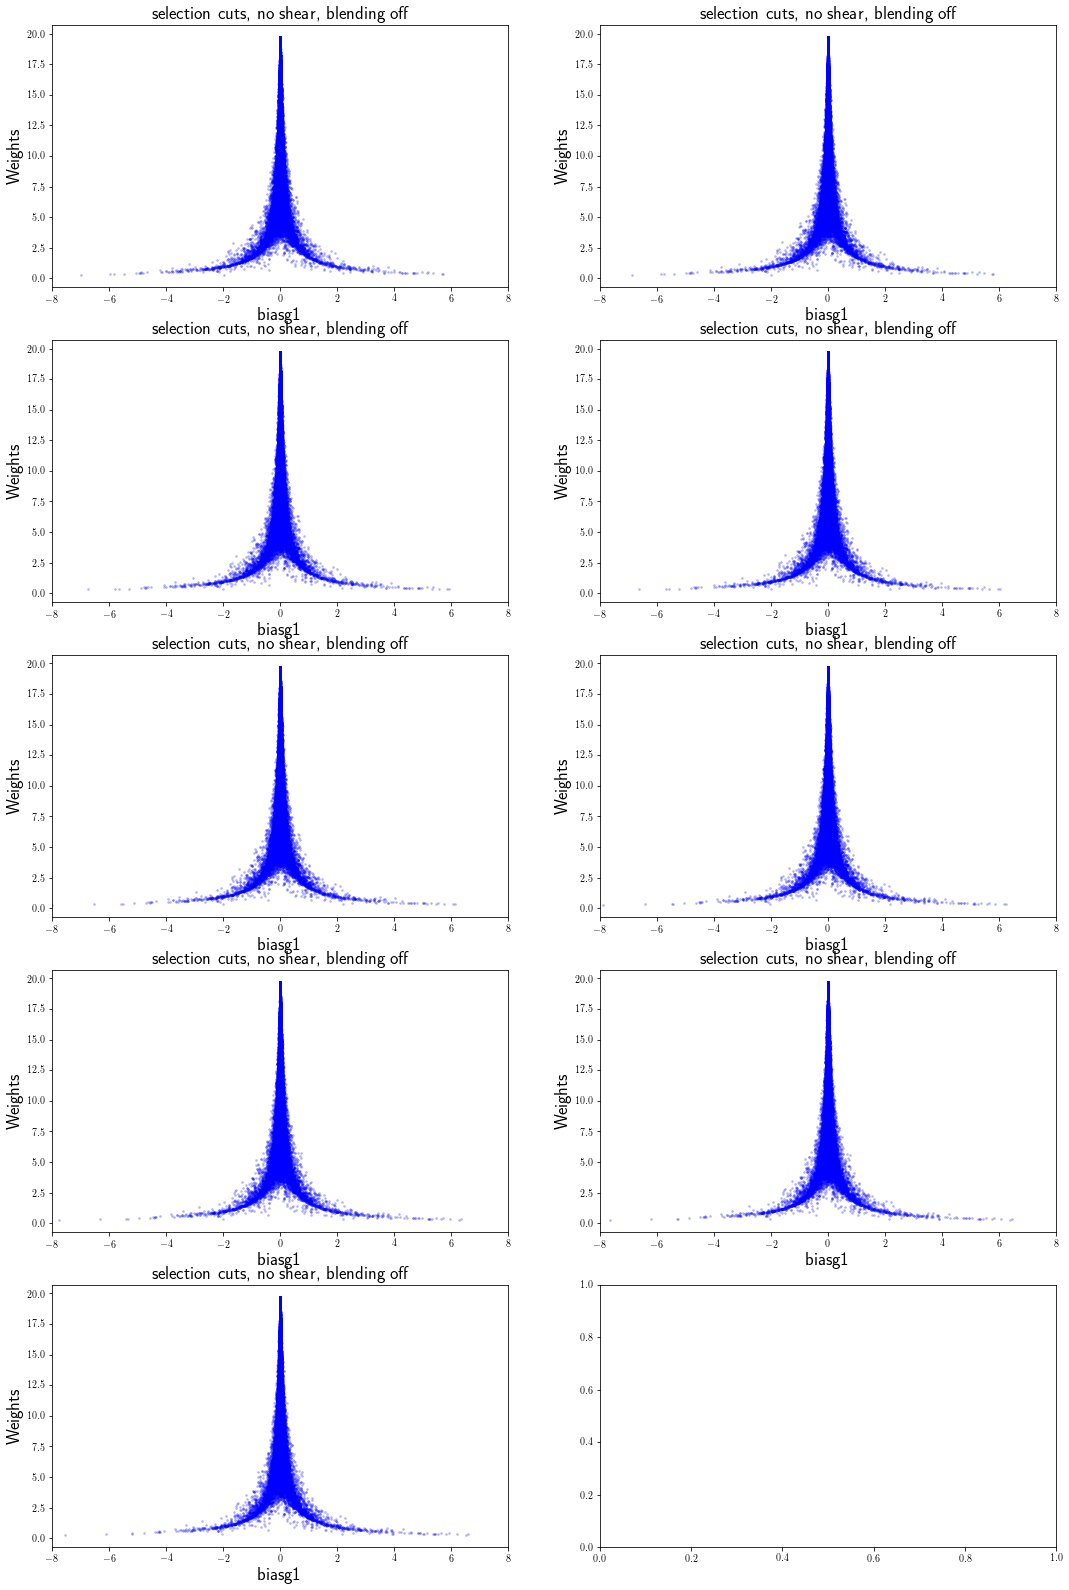

In [86]:
fig, axs = plt.subplots(5,2,figsize=(18,28))
axes = axs.flatten()
weights_bias_scatter(axes[0], fcats[0], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[1], fcats[1], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[2], fcats[2], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[3], fcats[3], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[4], fcats[4], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[5], fcats[5], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[6], fcats[6], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[7], fcats[7], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[8], fcats[8], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")

# comparisons with old catalogue

## all catalogue

In [11]:
ccat2, cfcat2 = maps.get_intersection_cats([cat2, fcat2])
print(len(ccat2))
print(len(cfcat2))

802031
802031


(0, 1000.0)

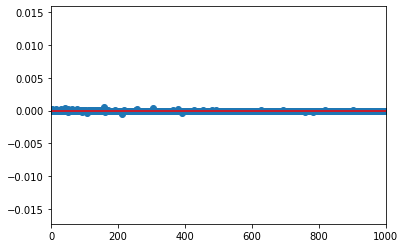

In [12]:
plt.scatter(ccat2['snr_grpf'], cfcat2['snr_grpf']-ccat2['snr_grpf'])
plt.plot([0, 1e5], [0, 0], c='r')
plt.xlim(0,1e3)

In [13]:
cond = ccat2['snr_grpf'] > 0 
fcond = cfcat2['snr_grpf'] > 0 
np.max( np.absolute(cfcat2[fcond]['snr_grpf']-ccat2[cond]['snr_grpf']) / ccat2[cond]['snr_grpf'])

0.00033703435

In [15]:
np.max( np.absolute(cfcat2[fcond]['dg1_grp']-ccat2[cond]['dg1_grp']) / ccat2[cond]['dg1_grp'])

0.000213664

1.3018836


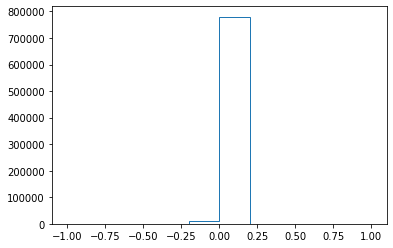

In [24]:
# xs = np.ma.log10(np.absolute(ccat2[cond]['bias_g1_grp']))
ys = np.ma.log10( (np.absolute(cfcat2[fcond]['bias_g1_grp']-ccat2[cond]['bias_g1_grp']))/ccat2[cond]['bias_g1_grp'])

plt.hist(ys,  histtype='step', range=[-1,1]);
print(np.max(ys))
# 1e5], [0, 0], c='r')
# plt.xlim(-6,6)


In [108]:
cond = ccat2['snr_grpf'] > 0 
fcond = cfcat2['snr_grpf'] > 0 
np.max( np.absolute(cfcat2[fcond]['bias_g1_grp']-ccat2[cond]['bias_g1_grp']) / ccat2[cond]['bias_g1_grp'])

20.039349

## selected catalogues

In [25]:
cscat2, cfscat2 = maps.get_intersection_cats([scat2, fscat2])
print(len(cscat2))
print(len(cfscat2))

75323
75323


In [26]:
cond = cscat2['snr_grpf'] > 0 
fcond = cfscat2['snr_grpf'] > 0 
np.max( np.absolute(cfscat2[fcond]['bias_g1_grp']-cscat2[cond]['bias_g1_grp']) / cscat2[cond]['bias_g1_grp'])

0.25136

# Money Plot 

## Median 

In [96]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])
orig_ids = list(range(len(fcats[0])))

In [97]:
# median_prep = money.prepare_money_plot(g1s, orig_ids, fcats, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
#                          N=int(1e4), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])

In [106]:
# pickle.dump(median_prep, open("data/fmedian_prep.p", 'wb'))

In [ ]:
median_prep = pickle.read(open("data/fmedian_prep.p", 'rb'), encoding='latin1')

In [107]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep

In [108]:
# #save boostrapped values too. 
# pickle.dump( (boot_values, boot_values_grp), open("data/fmedian_bootstraps.p", 'wb'))

Results for fits of unblended case: 


 value b0:     1.513e-03
error b0:     4.331e-05
value b1:     3.575e-07
error b1:     1.122e-07
error correlation coefficient: 9.949e-02

Results for fits of blended case: 


 value b0:     3.662e-03
error b0:     9.246e-05
value b1:     -5.557e-06
error b1:     1.757e-06
error correlation coefficient: -1.325e-01


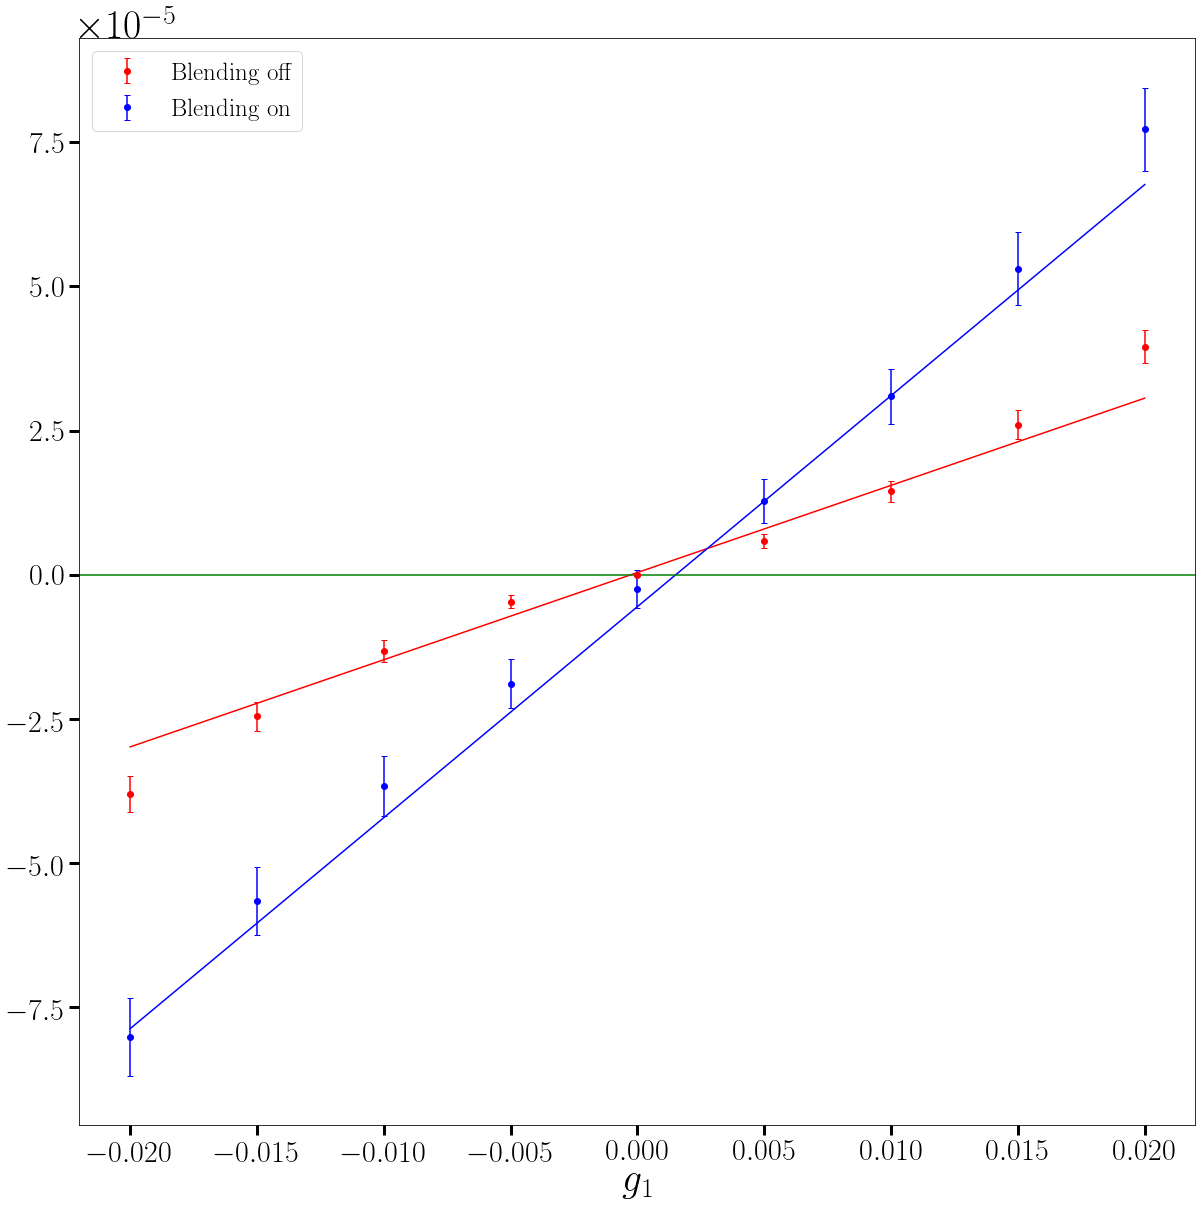

In [102]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

## Weighted. 

In [87]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])
orig_ids = list(range(len(fcats[0])))

In [88]:
# weights_prep = money.prepare_money_plot(g1s, orig_ids, fcats, weights.wmean, fit_procedure=money.chi_sq_fit, 
#                                         N=int(1e4), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
#                                         args_grp=['1', 'grp', 'component'])

In [105]:
# pickle.dump(weights_prep, open("data/fweights_prep.p", 'wb'))

In [ ]:
weights_prep = pickle.read(open("data/fweights_prep.p", 'rb'), encoding='latin1')

In [109]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep

In [110]:
# pickle.dump( (boot_values, boot_values_grp), open("data/fweights_bootstraps.p", 'wb'))

Results for fits of unblended case: 


 value b0:     5.303e-02
error b0:     3.157e-04
value b1:     -2.569e-04
error b1:     1.145e-04
error correlation coefficient: 2.980e-03

Results for fits of blended case: 


 value b0:     5.579e-02
error b0:     3.157e-04
value b1:     -2.804e-04
error b1:     1.145e-04
error correlation coefficient: 2.980e-03


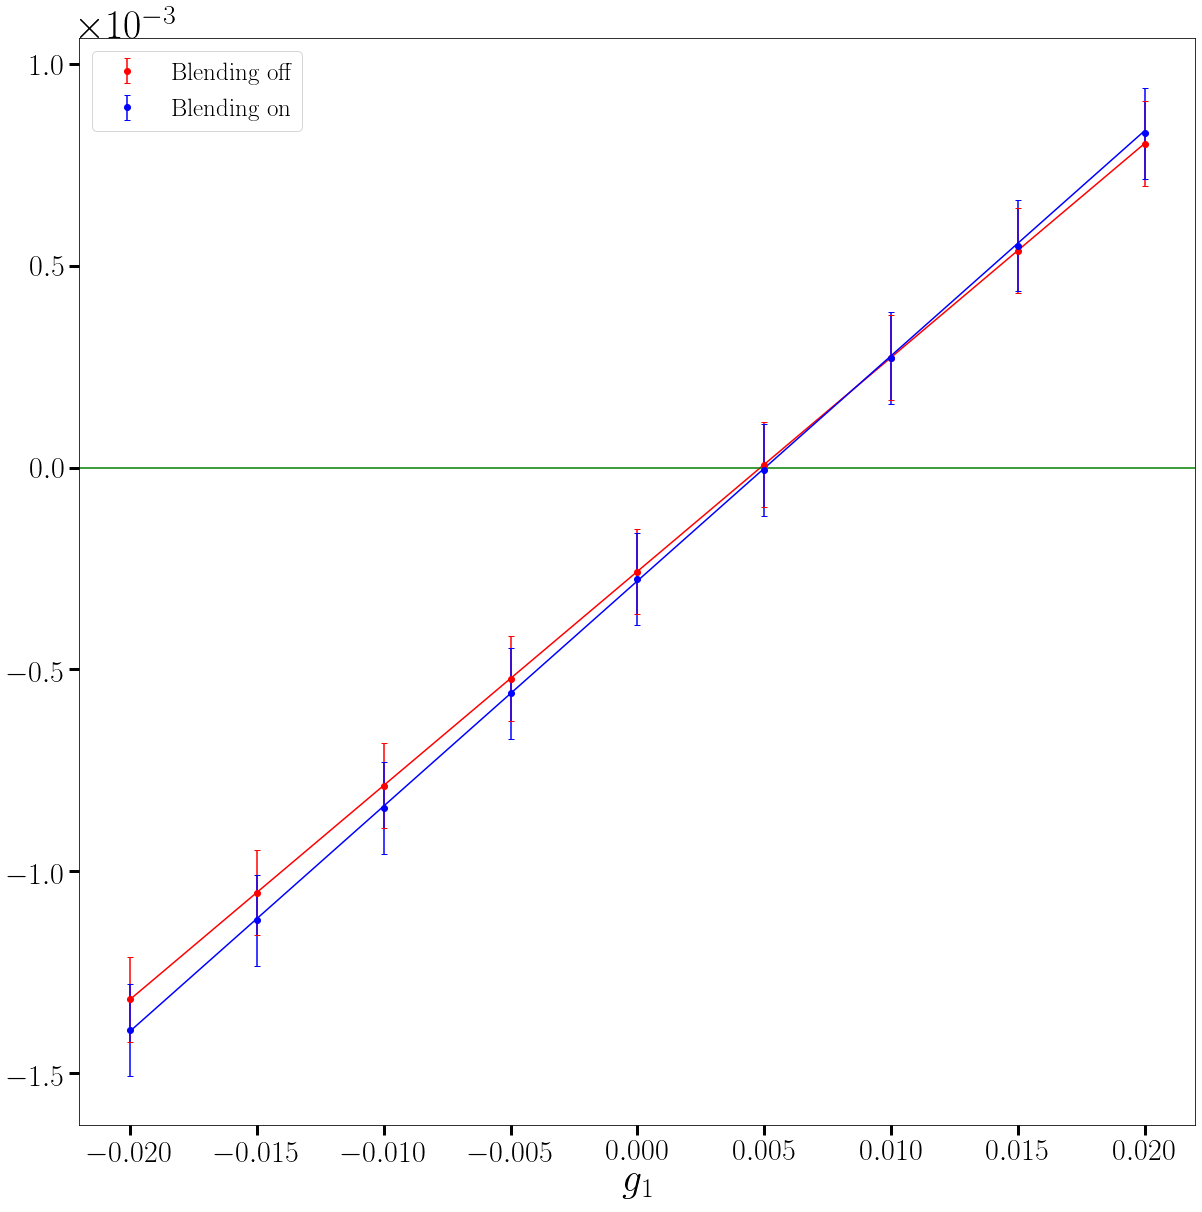

In [104]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas1, ticks1=None, labely1=None)

### check boostrapped values 

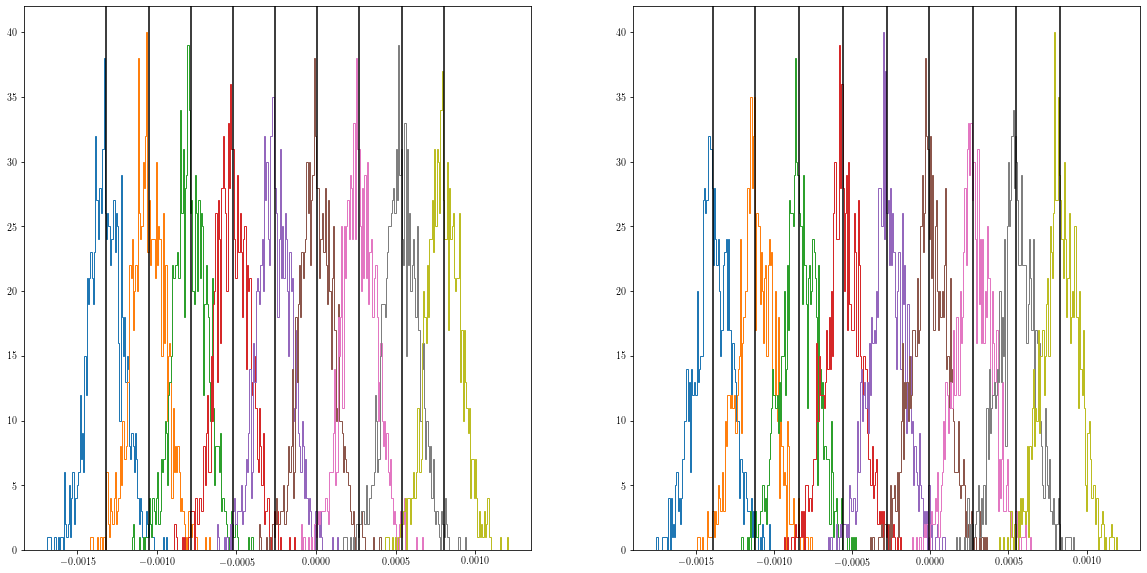

In [76]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
ax1,ax2 = axs.flatten()
for val, val_grp, vals, vals_grp  in zip(values, values_grp, boot_values, boot_values_grp): 
    ax1.hist(vals, histtype='step', bins=100)
    ax1.axvline(val,color='k')
    ax2.hist(vals_grp, histtype='step', bins=100)
    ax2.axvline(val_grp, color='k')